In [3]:
from logLikeli import logLike

import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import imp
import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
%matplotlib inline

In [4]:
import utils

In [5]:
from utils import Marray_EEfirst as Marray
from utils import Minv as Minv
from utils import evaluateLikelihood as evaluateL

In [6]:
import dynesty
from dynesty import plotting as dyplot
## import planck function 
from pysm.common import B as pf
from Fg_template import sync_ps, dust_ps

## data

In [43]:
A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
dust_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p56_from_RJ.npy')

A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')
sync_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p0_from_RJ.npy')

In [125]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise'

cl_f_all_ali = np.load('%s/cl_f_all.npy'%path); cl_f_ali = np.mean(cl_f_all_ali, axis = 0)

## to include the dust and sync cross ps into the fiducial ps. Only BB for now; 2020.07.13
# cl_f_all_ali[:,2] +=  sync_dl_RJ + dust_dl_RJ #

# cl_hat_all_ali = np.load('%s/cl_hat_fore_all.npy'%path) 
# cl_hat_0_ali = cl_hat_all_ali[10]

cl_hat_0_ali = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/cl_hat_r0.npy')

nl_all_ali = np.load('%s/nl_all.npy'%path)
nl_mean_ali = np.mean(nl_all_ali, axis = 0) ## EE EB BB

In [8]:
cl_camb = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy')
cl_th_BB_ali = cl_camb + nl_mean_ali[2]

In [9]:
lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

In [60]:
cmb_bb = lensingB[2] + bb_05

b.bin_cell(cmb_bb[0:nmtlmax+1])

## Method

In [35]:
from utils import testL as testL

In [126]:
LogL = logLike(2,10) 

 ## calculate logL.cl_f; logL.Cov  

LogL.M(cl_f_all = cl_f_all_ali, SamNum=500)

In [102]:
# LogL.run(cl_hat=cl_hat_0_ali[2], cl_th=cl_th_BB_ali, sbin=1)

In [33]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

Nf = 2

b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,lbin+1)

In [127]:
add_dust = True
 
cl_hat_fore_ali = cl_hat_0_ali[2] #+ sync_dl_RJ + dust_dl_RJ
        
def log_likelihood(cube, subtract = False):
    r_i = cube[0];
    beta_s = cube[1];
    beta_d = cube[2]
    
    bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

    bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

    cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]
    
    if subtract:
        
        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean_ali[2] 
    
        logL = LogL.run(cl_hat=(cl_hat_fore_ali- sync_ps(A_s_RJ, beta_s, 10) - dust_ps(A_d_RJ, beta_d, 10)) , cl_th = C_l,sbin=1);
        
    else:
        C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s_RJ, beta_s, 10) + dust_ps(A_d_RJ, beta_d, 10);
        
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=1);
        
    
    return np.real(logL)

def prior(cube):
    
    r = cube[0]*2 - 1
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2] + 1 ## from 1 to 2
        
    return [r, beta_s, beta_d]

In [128]:
sampler = dynesty.NestedSampler(log_likelihood, prior, 3, nlive=400)
sampler.run_nested()
results = sampler.results

/home/jianyao/Likelihood/utils.py:217: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))
/home/jianyao/Likelihood/utils.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)
1574it [01:08,  5.64it/s, bound: 1 | nc: 1 | ncall: 15752 | eff(%):  9.992 | loglstar:   -inf < -281.634 <    inf | logz: -290.452 +/-    nan | dlogz: 271.309 >  0.409]  /home/jianyao/Likelihood/utils.py:217: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))
/home/jianyao/Likelihood/utils.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)
5204it [01:50, 102.08it/s, bound: 16 | nc: 1 | ncall: 25135 | eff(%): 20.704 | loglstar:   -inf < -14.552 <    inf | logz: -26.257 +/-    nan | dlogz:

In [109]:
truth = np.array([0, -3.0, 1.558])

sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

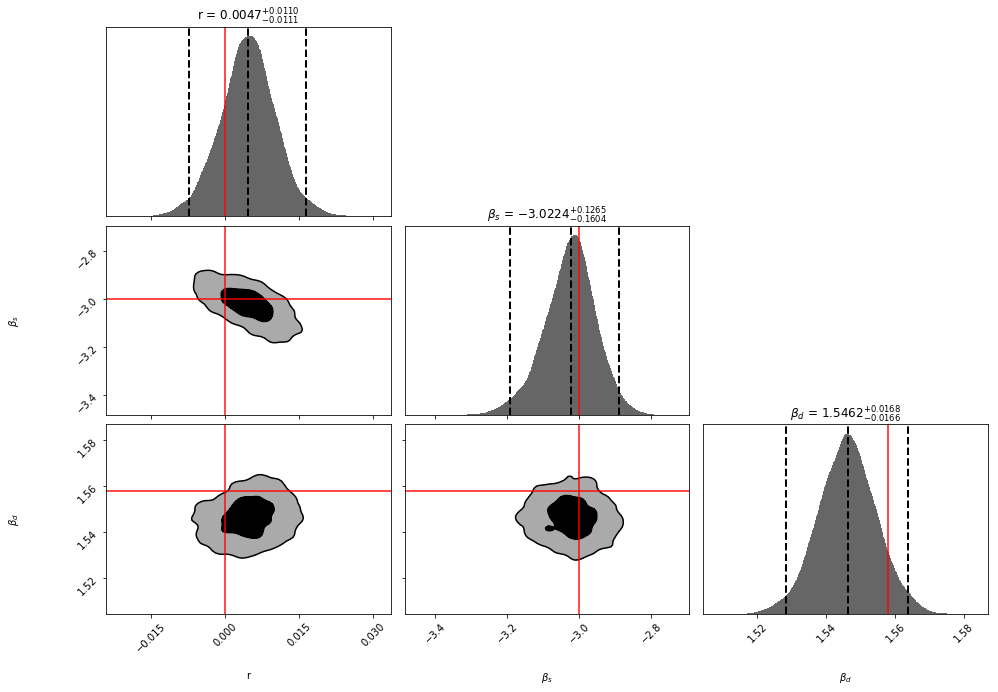

In [129]:
## cl_hat_r0

labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# plt.savefig('./fig_results/dynesty/cl_hat_r0_fiducial_only_CMB_Noise.pdf', format = 'pdf')

###  (cl + fl) as new cl

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18da6794e0>,
       dtype=object))

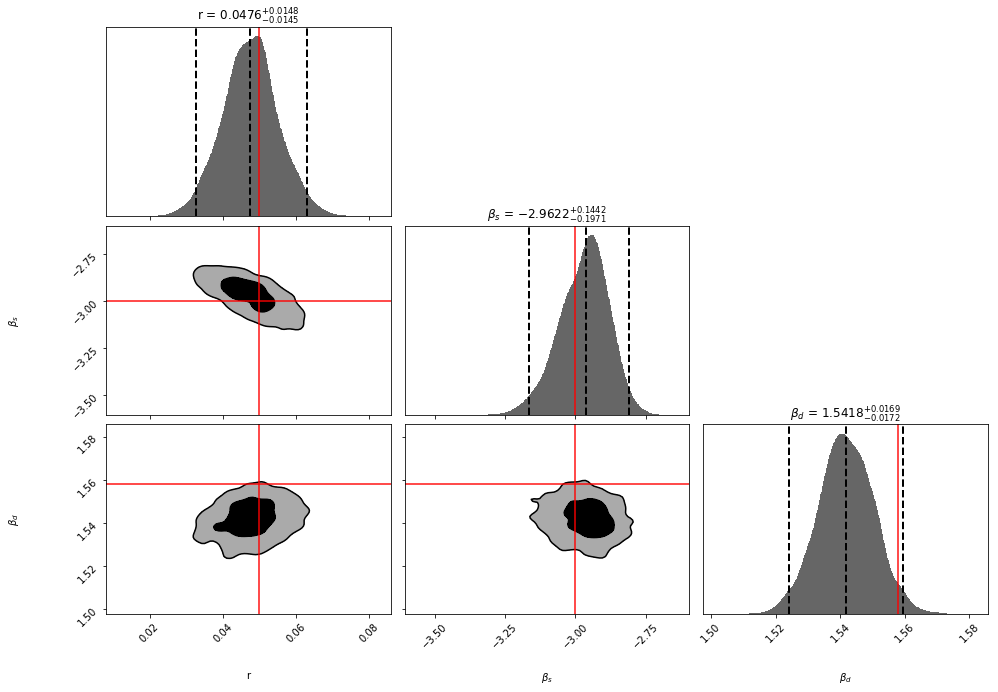

In [95]:
## fiducial bp include CMB + noise only

labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18dcc67e48>,
       dtype=object))

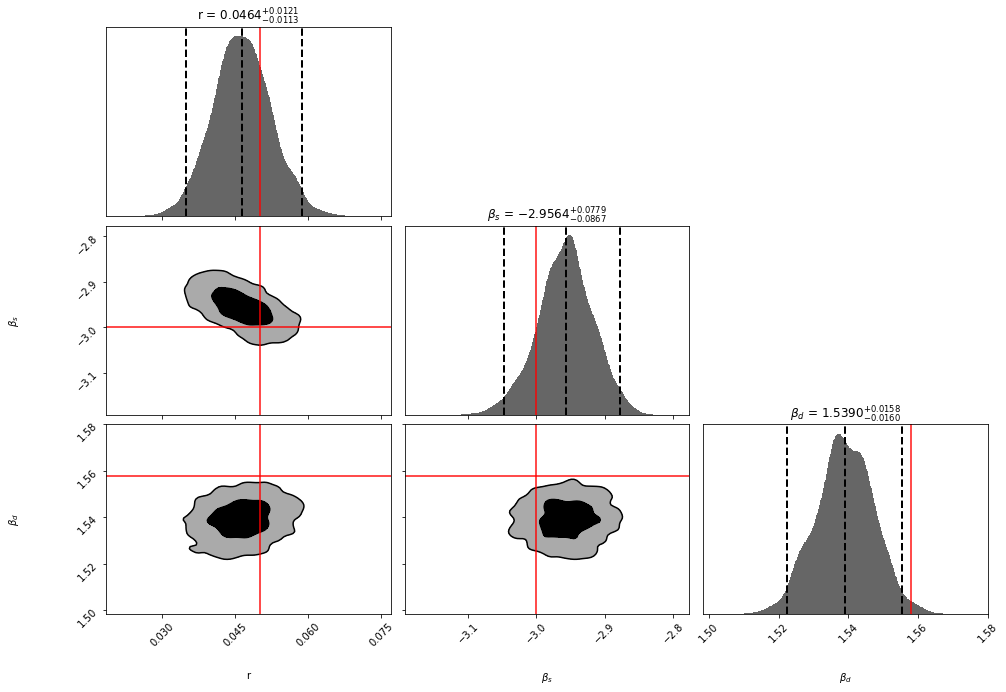

In [87]:
## fiducial bp add synchrotron only

labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18dbeb1710>,
       dtype=object))

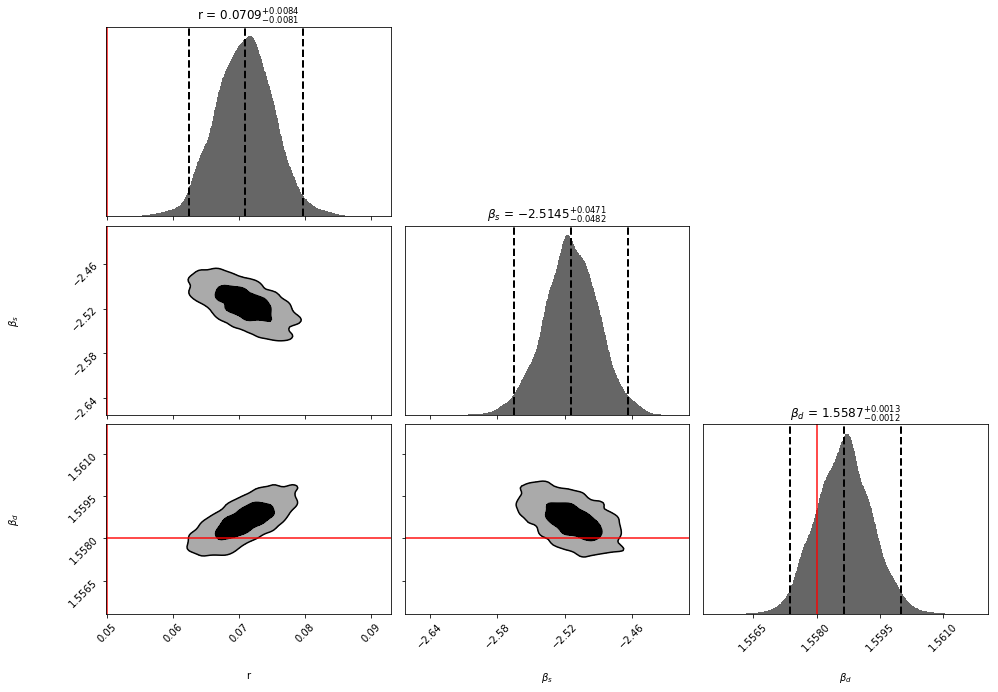

In [91]:
## fiducial bp include dust and synchrotron

labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

### (cl_hat - fl ) as new cl_hat,

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9db15df470>,
       dtype=object))

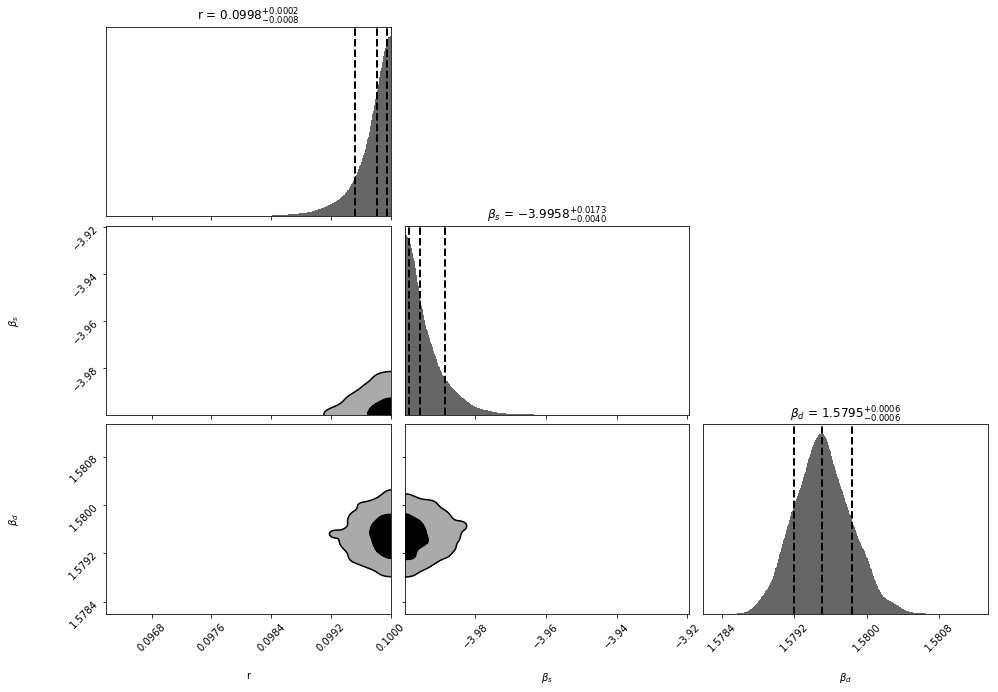

In [93]:
labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = [0.16, 0.5, 0.84], quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85